In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)

from scipy.stats import skew, kurtosis

import pygris
from shapely.geometry import Polygon

import shapely

In [2]:
df = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/FimaNfipClaims.parquet.gzip")

In [187]:
df_geographic_unique = df[['state', 'reportedZipCode', 'countyCode', 'censusTract', 'censusBlockGroupFips', 'latitude', 'longitude', 'yearOfLoss']].drop_duplicates()

In [188]:
df_geographic_unique = df_geographic_unique.dropna(subset=['censusBlockGroupFips'])

In [189]:
# df_geographic_unique['reportedZipCode'] = df_geographic_unique['reportedZipCode'].dropna().astype(int).astype(str)
# df_geographic_unique['reportedZipCode'] = [zipcode.zfill(5) for zipcode in df_geographic_unique['reportedZipCode']]

df_geographic_unique['censusBlockGroupFips'] = [str(int(float(i))) for i in df_geographic_unique['censusBlockGroupFips']]
df_geographic_unique['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_geographic_unique['censusBlockGroupFips']]

# df_geographic_unique['countyCode'] = [str(int(float(i))) for i in df_geographic_unique['countyCode']]
# df_geographic_unique['countyCode'] = [censusBG.zfill(5) for censusBG in df_geographic_unique['countyCode']]

# df_geographic_unique['censusTract'] = [str(int(float(i))) for i in df_geographic_unique['censusTract']]
# df_geographic_unique['censusTract'] = [censusBG.zfill(11) for censusBG in df_geographic_unique['censusTract']]

In [192]:
# Define bins and labels for yearOfLoss_2000_2021
bins_2000_2021 = [df_geographic_unique['yearOfLoss'].min(), 2010, 2020, df_geographic_unique['yearOfLoss'].max() + 1]
labels_2000_2021 = [2000, 2010, 2020]

df_geographic_unique['yearOfLoss_2000_2021'] = pd.cut(df_geographic_unique['yearOfLoss'], bins=bins_2000_2021, labels=labels_2000_2021, right=False).astype(int)

# Define bins and labels for yearOfLoss_1990_2021
bins_1990_2021 = [df_geographic_unique['yearOfLoss'].min(), 2000, 2010, 2020, df_geographic_unique['yearOfLoss'].max() + 1]
labels_1990_2021 = [1990, 2000, 2010, 2020]

df_geographic_unique['yearOfLoss_1990_2021'] = pd.cut(df_geographic_unique['yearOfLoss'], bins=bins_1990_2021, labels=labels_1990_2021, right=False).astype(int)

df_geographic_unique = df_geographic_unique.drop(columns='yearOfLoss')

In [193]:
df_geographic_unique.head()

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,corrected_state_lat_long,yearOfLoss_2000_2021,yearOfLoss_1990_2021
0,CA,92056.0,6073.0,6.073019e+09,060730185123,33.2,-117.3,CA,2000,1990
1,LA,70131.0,22071.0,2.207100e+10,220710006163,29.9,-90.0,LA,2000,2000
2,FL,32566.0,12113.0,1.211301e+10,121130108152,30.4,-86.9,FL,2000,1990
3,SC,29902.0,45013.0,4.501300e+10,450130007002,32.4,-80.7,SC,2000,1990
4,FL,32940.0,12009.0,1.200906e+10,120090631073,28.3,-80.7,FL,2000,1990


## Read shapefiles

In [8]:
states = pygris.states()

state_df = states[['STUSPS', 'NAME', 'geometry']]

Using the default year of 2021


In [9]:
#Checking if all states found in our dataset are in the US Census Bureau TIGER/Line and cartographic boundary shapefiles

unique_states = df_geographic_unique['state'].unique()
state_STUSPS_unique = state_df['STUSPS'].unique()

np.all(np.isin(unique_states, state_STUSPS_unique))

True

In [10]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/lat_long_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
lat_long_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))

In [11]:
chunk_size = 25000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 400000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/BG_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)

# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
BG_df = pd.concat(gdf_list, ignore_index=True)

BG_df['year'] = BG_df['year'].replace({2012: 2010, 2021: 2020})
BG_df = BG_df.drop_duplicates(subset=['GEOID', 'year'])

In [12]:
chunk_size = 25000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 100000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/zipcode_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)
    
# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
zipcode_df = pd.concat(gdf_list, ignore_index=True)

zipcode_df['year'] = zipcode_df['year'].replace({2012: 2010, 2021: 2020})
zipcode_df = zipcode_df.drop_duplicates(subset=['ZIPcode', 'year'])

In [13]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/County_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
County_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))

County_df['year'] = County_df['year'].replace({2012: 2010, 2021: 2020})
County_df = County_df.drop_duplicates(subset=['CountyID', 'year'])

In [14]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/Tract_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
Tract_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))
Tract_df['year'] = Tract_df['year'].replace({2012: 2010, 2021: 2020})
Tract_df = Tract_df.drop_duplicates(subset=['censusTractID', 'year'])

## Create centroid

In [15]:
# 1. Calculate centroids

lat_long_df['centroid_lat_long'] = lat_long_df['geometry'].centroid

BG_df['centroid_BG'] = BG_df['geometry'].centroid

zipcode_df['centroid_zipcode'] = zipcode_df['geometry'].centroid

County_df['centroid_county'] = County_df['geometry'].centroid

Tract_df['centroid_tract'] = Tract_df['geometry'].centroid

##  Spatial join: for each centroid, determine which state it intersects (either falls within or on the boundary)

In [16]:
# 2. Spatial join: for each centroid, determine which state it intersects (either falls within or on the boundary)

lat_long_df.set_geometry('centroid_lat_long', inplace=True)
lat_long_df.crs = "EPSG:4269"

lat_long_df = lat_long_df.to_crs(state_df.crs)

joined = gpd.sjoin(lat_long_df, state_df, predicate='within')

# 3. Create the 'corrected_state' column using the 'STUSPS' column from the join operation
lat_long_df['corrected_state_lat_long'] = joined['STUSPS']
lat_long_df['corrected_state_lat_long'] = lat_long_df['corrected_state_lat_long'].fillna('Not_within_any_state')

#-------------

BG_df.set_geometry('centroid_BG', inplace=True)
BG_df.crs = "EPSG:4269"

BG_df = BG_df.to_crs(state_df.crs)

joined = gpd.sjoin(BG_df.set_geometry('centroid_BG'), state_df, predicate='within')

BG_df['corrected_state_BG'] = joined['STUSPS']
BG_df['corrected_state_BG'] = BG_df['corrected_state_BG'].fillna('Not_within_any_state')

#-------------

zipcode_df.set_geometry('centroid_zipcode', inplace=True)
zipcode_df.crs = "EPSG:4269"

zipcode_df = zipcode_df.to_crs(state_df.crs)

joined = gpd.sjoin(zipcode_df.set_geometry('centroid_zipcode'), state_df, predicate='within')

zipcode_df['corrected_state_zipcode'] = joined['STUSPS']
zipcode_df['corrected_state_zipcode'] = zipcode_df['corrected_state_zipcode'].fillna('Not_within_any_state')

#-------------

County_df.set_geometry('centroid_county', inplace=True)
County_df.crs = "EPSG:4269"

County_df = County_df.to_crs(state_df.crs)

joined = gpd.sjoin(County_df.set_geometry('centroid_county'), state_df, predicate='within')

County_df['corrected_state_county'] = joined['STUSPS']
County_df['corrected_state_county'] = County_df['corrected_state_county'].fillna('Not_within_any_state')

#-------------

Tract_df.set_geometry('centroid_tract', inplace=True)
Tract_df.crs = "EPSG:4269"

Tract_df = Tract_df.to_crs(state_df.crs)

joined = gpd.sjoin(Tract_df.set_geometry('centroid_tract'), state_df, predicate='within')

Tract_df['corrected_state_tract'] = joined['STUSPS']
Tract_df['corrected_state_tract'] = Tract_df['corrected_state_tract'].fillna('Not_within_any_state')

## Combining with the original dataframe

In [194]:
# Setting the multi-index on lat_long_df
lat_long_df.set_index(['latitude', 'longitude'], inplace=True)

# Mapping the values
df_geographic_unique['corrected_state_lat_long'] = df_geographic_unique.set_index(['latitude', 'longitude']).index.map(lat_long_df['corrected_state_lat_long'])

# Resetting the index of lat_long_df (optional, but good practice)
lat_long_df.reset_index(inplace=True)

In [198]:
# Initial mapping with multi-index
BG_df.set_index(['GEOID', 'year'], inplace=True)
df_geographic_unique['corrected_state_BG'] = df_geographic_unique.set_index(['censusBlockGroupFips', 'yearOfLoss_1990_2021']).index.map(BG_df['corrected_state_BG'])

# Find rows with NaN values in 'corrected_state_BG'
na_rows = df_geographic_unique['corrected_state_BG'].isna()

# Reset index of BG_df
df_single_index = BG_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'GEOID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='GEOID', keep='first')

# Map these rows using only the 'GEOID'
df_geographic_unique.loc[na_rows, 'corrected_state_BG'] = df_geographic_unique.loc[na_rows, 'censusBlockGroupFips'].map(df_single_index.set_index('GEOID')['corrected_state_BG'])

# Resetting the index of BG_df (return to multi-index)
BG_df.reset_index(inplace=True)

In [19]:
# Initial mapping with multi-index
zipcode_df.set_index(['ZIPcode', 'year'], inplace=True)
df_geographic_unique['corrected_state_zipcode'] = df_geographic_unique.set_index(['reportedZipCode', 'yearOfLoss_2000_2021']).index.map(zipcode_df['corrected_state_zipcode'])

# Find rows with NaN values in 'corrected_state'
na_rows = df_geographic_unique['corrected_state_zipcode'].isna()

# Reset index
df_single_index = zipcode_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'ZIPcode' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='ZIPcode', keep='first')

# Map these rows using only the 'ZIPcode'
df_geographic_unique.loc[na_rows, 'corrected_state_zipcode'] = df_geographic_unique.loc[na_rows, 'reportedZipCode'].map(df_single_index.set_index('ZIPcode')['corrected_state_zipcode'])

# Resetting the index (return to multi-index)
zipcode_df.reset_index(inplace=True)

In [20]:
# Initial mapping with multi-index
County_df.set_index(['CountyID', 'year'], inplace=True)
df_geographic_unique['corrected_state_county'] = df_geographic_unique.set_index(['countyCode', 'yearOfLoss_1990_2021']).index.map(County_df['corrected_state_county'])

# Find rows with NaN values in 'corrected_state'
na_rows = df_geographic_unique['corrected_state_county'].isna()

# Reset index
df_single_index = County_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'CountyID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='CountyID', keep='first')

# Map these rows using only the 'CountyID'
df_geographic_unique.loc[na_rows, 'corrected_state_county'] = df_geographic_unique.loc[na_rows, 'countyCode'].map(df_single_index.set_index('CountyID')['corrected_state_county'])

# Resetting the index (return to multi-index)
County_df.reset_index(inplace=True)

In [21]:
# Initial mapping with multi-index
Tract_df.set_index(['censusTractID', 'year'], inplace=True)
df_geographic_unique['corrected_state_tract'] = df_geographic_unique.set_index(['censusTract', 'yearOfLoss_2000_2021']).index.map(Tract_df['corrected_state_tract'])

# Find rows with NaN values in 'corrected_state'
na_rows = df_geographic_unique['corrected_state_tract'].isna()

# Reset index
df_single_index = Tract_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'CountyID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='censusTractID', keep='first')

# Map these rows using only the 'CountyID'
df_geographic_unique.loc[na_rows, 'corrected_state_tract'] = df_geographic_unique.loc[na_rows, 'censusTract'].map(df_single_index.set_index('censusTractID')['corrected_state_tract'])

# Resetting the index (return to multi-index)
Tract_df.reset_index(inplace=True)

In [22]:
df_geographic_unique

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,yearOfLoss_2000_2021,yearOfLoss_1990_2021,corrected_state_lat_long,corrected_state_BG,corrected_state_zipcode,corrected_state_county,corrected_state_tract
0,CA,92056,06073,06073018512,060730185123,33.2,-117.3,2000,1990,CA,CA,CA,CA,CA
1,LA,70131,22071,22071000616,220710006163,29.9,-90.0,2000,2000,LA,LA,LA,LA,LA
2,FL,32566,12113,12113010815,121130108152,30.4,-86.9,2000,1990,FL,FL,FL,FL,FL
3,SC,29902,45013,45013000700,450130007002,32.4,-80.7,2000,1990,SC,SC,SC,SC,SC
4,FL,32940,12009,12009063107,120090631073,28.3,-80.7,2000,1990,FL,FL,FL,FL,FL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584234,MI,49306,26081,26081011001,260810110013,43.1,-85.6,2020,2020,MI,MI,MI,MI,MI
2584235,MI,49073,26015,26015010100,260150101004,42.6,-85.2,2020,2020,MI,MI,MI,MI,MI
2584236,ND,58801,38105,38105953500,381059535001,48.4,-103.7,2020,2020,ND,ND,ND,ND,ND
2584238,TX,75211,48113,48113021200,481130212001,32.7,-96.9,2020,2020,TX,TX,TX,TX,TX


## Finding Mismatches and tagging those

In [199]:
df_copy = df.copy()

In [200]:
# df_copy = df_copy.dropna(subset=['censusBlockGroupFips', 'reportedZipCode', 'countyCode'])
df_copy = df_copy.dropna(subset=['censusBlockGroupFips'])

In [201]:
# df_copy['reportedZipCode'] = df_copy['reportedZipCode'].dropna().astype(int).astype(str)
# df_copy['reportedZipCode'] = [zipcode.zfill(5) for zipcode in df_copy['reportedZipCode']]

df_copy['censusBlockGroupFips'] = [str(int(float(i))) for i in df_copy['censusBlockGroupFips']]
df_copy['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_copy['censusBlockGroupFips']]

# df_copy['countyCode'] = [str(int(float(i))) for i in df_copy['countyCode']]
# df_copy['countyCode'] = [censusBG.zfill(5) for censusBG in df_copy['countyCode']]

# df_copy['censusTract'] = [str(int(float(i))) for i in df_copy['censusTract']]
# df_copy['censusTract'] = [censusBG.zfill(11) for censusBG in df_copy['censusTract']]

#### LAT LONG Analysis

In [202]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_latlong = df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_lat_long']]

In [203]:
mismatched_df_latlong

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,corrected_state_lat_long,yearOfLoss_2000_2021,yearOfLoss_1990_2021,corrected_state_BG
7,HI,96792.0,15003.0,1.500301e+10,150030097031,21.4,-158.2,Not_within_any_state,2000,1990,Not_within_any_state
21,SC,29577.0,45051.0,4.505105e+10,450510505002,33.7,-78.8,Not_within_any_state,2000,1990,SC
26,FL,32507.0,12033.0,1.203300e+10,120330026031,30.3,-87.4,Not_within_any_state,2000,1990,FL
46,FL,32507.0,12033.0,1.203300e+10,120330026032,30.3,-87.4,Not_within_any_state,2000,2000,FL
50,FL,32931.0,12009.0,1.200907e+10,120090683002,28.3,-80.6,Not_within_any_state,2000,1990,FL
...,...,...,...,...,...,...,...,...,...,...,...
2584136,WA,98332.0,53053.0,5.305307e+10,530530725041,47.3,-122.7,Not_within_any_state,2020,2020,WA
2584187,GA,31833.0,13285.0,1.328596e+10,132859610002,32.9,-85.2,AL,2020,2020,GA
2584200,NC,27954.0,37055.0,3.705597e+10,370559706021,35.9,-75.7,Not_within_any_state,2020,2020,NC
2584203,FL,33190.0,12086.0,1.208601e+10,120860106121,25.6,-80.3,Not_within_any_state,2020,2020,FL


In [204]:
mismatched_df_latlong_unique = mismatched_df_latlong[['latitude', 'longitude', 'state', 'corrected_state_lat_long']].drop_duplicates()

In [205]:
mismatched_df_latlong_unique[mismatched_df_latlong_unique['corrected_state_lat_long']=='Not_within_any_state'].shape[0]

1079

In [206]:
mismatched_df_latlong_unique.shape[0]

3510

In [211]:
# Setting the multi-index on lat_long_df
lat_long_df.set_index(['latitude', 'longitude'], inplace=True)

# Mapping the values
mismatched_df_latlong_unique['geometry_lat_long'] = mismatched_df_latlong_unique.set_index(['latitude', 'longitude']).index.map(lat_long_df['geometry_lat_long'])

# Resetting the index of lat_long_df (optional, but good practice)
lat_long_df.reset_index(inplace=True)

In [212]:
mismatched_df_latlong_unique

,latitude,longitude,state,corrected_state_lat_long,geometry_lat_long
7,21.4,-158.2,HI,Not_within_any_state,"POLYGON ((-158.25000 21.35000, -158.15000 21.3..."
21,33.7,-78.8,SC,Not_within_any_state,"POLYGON ((-78.85000 33.65000, -78.75000 33.650..."
26,30.3,-87.4,FL,Not_within_any_state,"POLYGON ((-87.45000 30.25000, -87.35000 30.250..."
50,28.3,-80.6,FL,Not_within_any_state,"POLYGON ((-80.65000 28.25000, -80.55000 28.250..."
53,25.0,-80.5,FL,Not_within_any_state,"POLYGON ((-80.55000 24.95000, -80.45000 24.950..."
...,...,...,...,...,...
2524851,45.0,-109.1,MT,WY,"POLYGON ((-109.15000 44.95000, -109.05000 44.9..."
2524852,45.0,-110.0,MT,WY,"POLYGON ((-110.05000 44.95000, -109.95000 44.9..."
2571888,30.6,-83.2,GA,FL,"POLYGON ((-83.25000 30.55000, -83.15000 30.550..."
2582083,41.7,-124.2,CA,Not_within_any_state,"POLYGON ((-124.25000 41.65000, -124.15000 41.6..."


In [213]:
mismatched_df_latlong_unique[(mismatched_df_latlong_unique['corrected_state_lat_long']=='Not_within_any_state') & (mismatched_df_latlong_unique['corrected_state_lat_long'].notna())]['state'].unique()

array(['HI', 'SC', 'FL', 'CT', 'MA', 'VA', 'NC', 'TX', 'NJ', 'MS', 'WA',
       'CA', 'MD', 'AL', 'NH', 'NY', 'ME', 'RI', 'GA', 'IL', 'MI', 'OR',
       'LA', 'MN', 'DE', 'WI', 'AK', 'PA', 'OH', 'VI', 'PR', 'UN', 'AZ',
       'IN', 'ND', 'WV', 'GU', 'MO', 'CO', 'MT'], dtype=object)

In [214]:
mismatched_df_latlong_unique[(mismatched_df_latlong_unique['corrected_state_lat_long']!='Not_within_any_state') & (mismatched_df_latlong_unique['corrected_state_lat_long'].notna())]

,latitude,longitude,state,corrected_state_lat_long,geometry_lat_long
95,38.9,-77.1,MD,VA,"POLYGON ((-77.15000 38.85000, -77.05000 38.850..."
150,30.3,-87.5,FL,AL,"POLYGON ((-87.55000 30.25000, -87.45000 30.250..."
240,36.6,-82.3,TN,VA,"POLYGON ((-82.35000 36.55000, -82.25000 36.550..."
274,30.4,-87.4,AL,FL,"POLYGON ((-87.45000 30.35000, -87.35000 30.350..."
1108,47.9,-97.0,ND,MN,"POLYGON ((-97.05000 47.85000, -96.95000 47.850..."
...,...,...,...,...,...
2524743,18.1,-67.1,OK,PR,"POLYGON ((-67.15000 18.05000, -67.05000 18.050..."
2524851,45.0,-109.1,MT,WY,"POLYGON ((-109.15000 44.95000, -109.05000 44.9..."
2524852,45.0,-110.0,MT,WY,"POLYGON ((-110.05000 44.95000, -109.95000 44.9..."
2571888,30.6,-83.2,GA,FL,"POLYGON ((-83.25000 30.55000, -83.15000 30.550..."


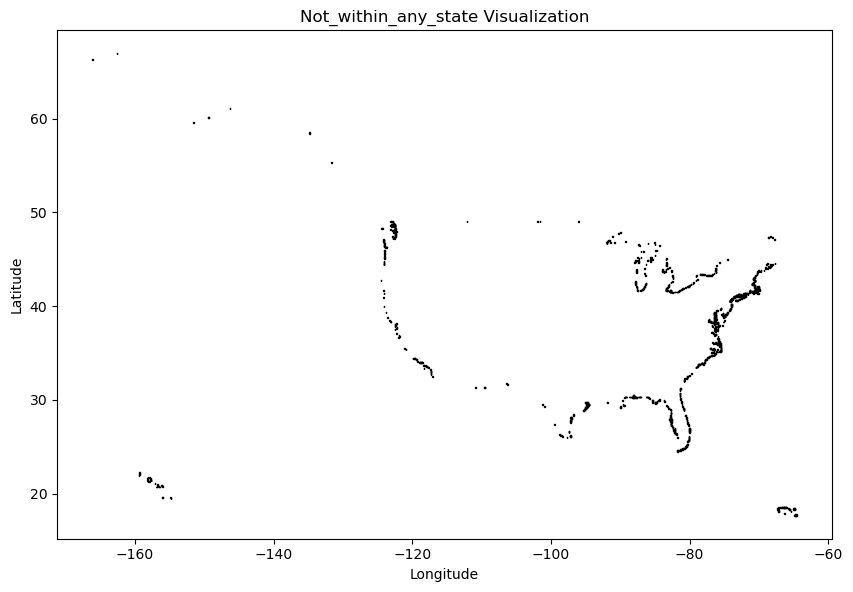

In [215]:
gdf = mismatched_df_latlong_unique[mismatched_df_latlong_unique['corrected_state_lat_long']=='Not_within_any_state']

# Only keep the necessary columns
gdf = gdf[['latitude', 'longitude', 'geometry_lat_long']]

gdf = gdf[gdf['longitude'] < 0]

gdf = gpd.GeoDataFrame(gdf, geometry='geometry_lat_long')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Not_within_any_state Visualization')

plt.show()

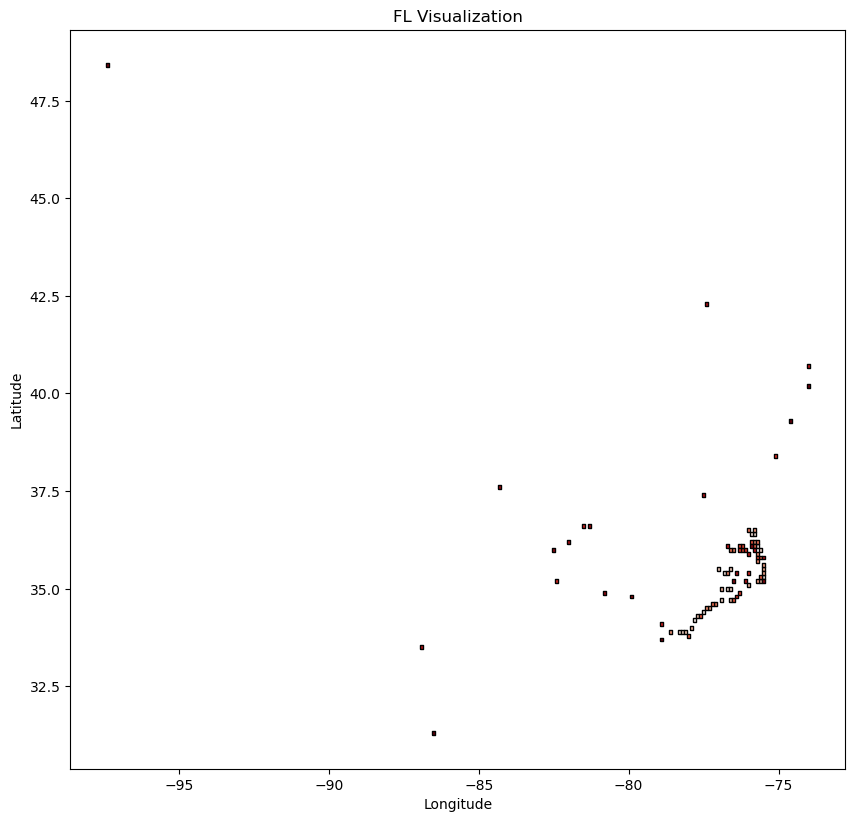

In [217]:
# gdf = mismatched_df_latlong_unique[(mismatched_df_latlong_unique['corrected_state_lat_long']!='Not_within_any_state')
#                                   & (mismatched_df_latlong_unique['corrected_state_lat_long']!='FL')]

# ['HI', 'SC', 'FL', 'CT', 'MA', 'VA', 'NC', 'TX', 'NJ', 'MS', 'WA',
       # 'CA', 'MD', 'AL', 'NH', 'NY', 'ME', 'RI', 'GA', 'IL', 'MI', 'OR',
       # 'LA', 'MN', 'DE', 'WI', 'AK', 'PA', 'OH', 'VI', 'PR', 'UN', 'AZ',
       # 'IN', 'ND', 'WV', 'GU', 'MO', 'CO', 'MT']

gdf = mismatched_df_latlong_unique[(mismatched_df_latlong_unique['state']=='NC')]

# Only keep the necessary columns
gdf = gdf[['latitude', 'longitude', 'geometry_lat_long']]

gdf = gpd.GeoDataFrame(gdf, geometry='geometry_lat_long')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('FL Visualization')

plt.show()

In [77]:
list_df_lat_long = list(mismatched_df_latlong[['latitude', 'longitude']].drop_duplicates().itertuples(index=False, name=None))

In [78]:
# Filter df_copy based on the list of tuples and get the number of rows
df_copy[df_copy.set_index(['latitude', 'longitude']).index.isin(list_df_lat_long)].shape[0]

399288

In [101]:
list_df_lat_long = list(lat_long_df[['latitude', 'longitude']].drop_duplicates().itertuples(index=False, name=None))

In [103]:
len(list_df_lat_long)

25127

#### BG

In [112]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_BG= df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_BG']]

In [113]:
mismatched_df_BG_unique = mismatched_df_BG[['censusBlockGroupFips', 'yearOfLoss_1990_2021', 'state', 'corrected_state_BG']].drop_duplicates()

In [115]:
mismatched_df_BG_unique[mismatched_df_BG_unique['corrected_state_BG']=='Not_within_any_state'].shape[0]

2144

In [116]:
mismatched_df_BG_unique.shape[0]

2187

In [117]:
# Initial mapping with multi-index
BG_df.set_index(['GEOID', 'year'], inplace=True)
mismatched_df_BG_unique['geometry_BG'] = mismatched_df_BG_unique.set_index(['censusBlockGroupFips', 'yearOfLoss_1990_2021']).index.map(BG_df['geometry_BG'])

# Find rows with NaN values in 'corrected_state_BG'
na_rows = mismatched_df_BG_unique['geometry_BG'].isna()

# Reset index of BG_df
df_single_index = BG_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'GEOID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='GEOID', keep='first')

# Map these rows using only the 'GEOID'
mismatched_df_BG_unique.loc[na_rows, 'geometry_BG'] = mismatched_df_BG_unique.loc[na_rows, 'censusBlockGroupFips'].map(df_single_index.set_index('GEOID')['geometry_BG'])

# Resetting the index of BG_df (return to multi-index)
BG_df.reset_index(inplace=True)

In [127]:
mismatched_df_BG_unique[(mismatched_df_BG_unique['corrected_state_BG']!='Not_within_any_state') & (mismatched_df_BG_unique['corrected_state_BG'].notna())]

,censusBlockGroupFips,yearOfLoss_1990_2021,state,corrected_state_BG,geometry_BG
1108,380350111001,1990,ND,MN,"POLYGON ((-97.02360 47.89810, -97.02460 47.895..."
12896,380350111001,2010,ND,MN,"POLYGON ((-97.02907 47.86074, -97.02910 47.864..."
19506,270270205003,1990,MN,ND,"POLYGON ((-96.77720 46.85850, -96.77331 46.856..."
22362,380350109001,1990,ND,MN,"POLYGON ((-97.02650 47.91410, -97.02190 47.913..."
50851,200430203003,2010,KS,MO,"POLYGON ((-94.94448 39.75997, -94.94446 39.760..."
85047,380170009011,1990,ND,MN,"POLYGON ((-96.78870 46.86170, -96.78360 46.861..."
85227,271190201003,1990,MN,ND,"POLYGON ((-97.03620 47.94180, -97.03271 47.934..."
116858,390610266002,1990,OH,KY,"POLYGON ((-84.50130 39.10337, -84.50062 39.103..."
156412,390610266001,2010,OH,KY,"POLYGON ((-84.50062 39.10349, -84.50052 39.103..."
194426,390610104001,2010,OH,KY,"POLYGON ((-84.69661 39.11284, -84.69515 39.113..."


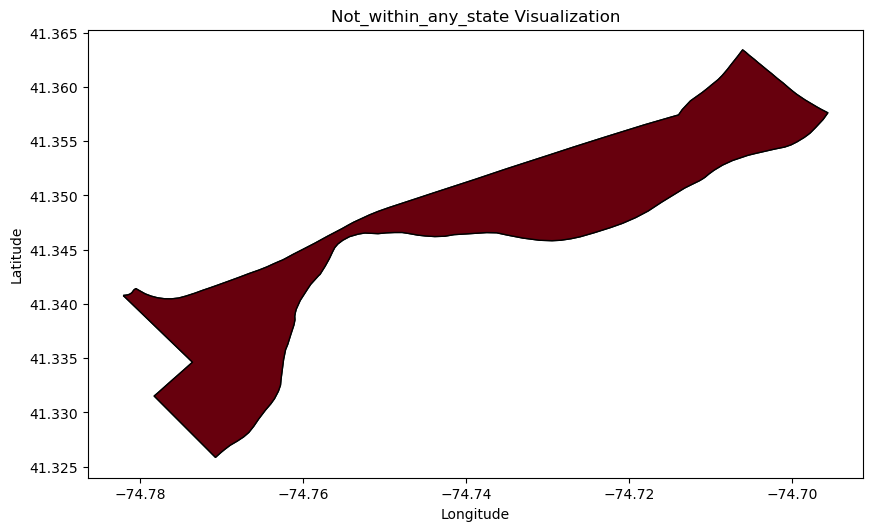

In [131]:
gdf = mismatched_df_BG_unique[mismatched_df_BG_unique['corrected_state_BG']=='NJ']

# Only keep the necessary columns
gdf = gdf[['censusBlockGroupFips', 'geometry_BG']]

gdf = gpd.GeoDataFrame(gdf, geometry='geometry_BG')

centroids = gdf.geometry.centroid

gdf = gdf[centroids.x < 0]

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Not_within_any_state Visualization')

plt.show()

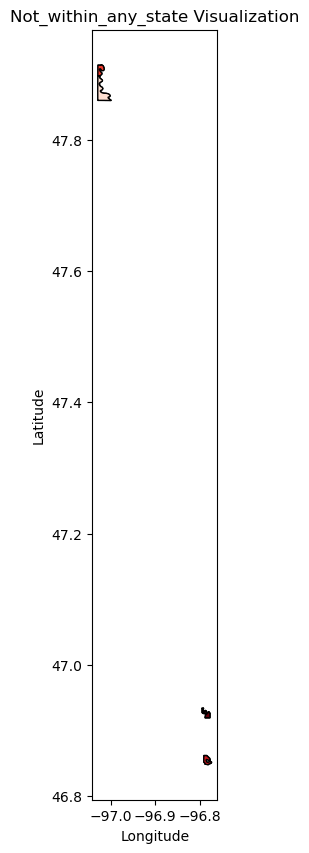

In [128]:
gdf = mismatched_df_BG_unique[mismatched_df_BG_unique['corrected_state_BG']=='MN']

# Only keep the necessary columns
gdf = gdf[['censusBlockGroupFips', 'geometry_BG']]

gdf = gpd.GeoDataFrame(gdf, geometry='geometry_BG')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Not_within_any_state Visualization')

plt.show()

In [31]:
list_df_BG = mismatched_df_BG['censusBlockGroupFips'].drop_duplicates().to_list()

In [32]:
df_copy[df_copy['censusBlockGroupFips'].isin(list_df_BG)].shape[0]

155976

In [43]:
list_df_BG_check = BG_df['GEOID'].drop_duplicates().to_list()

In [45]:
len(list_df_BG_check)

106781

In [50]:
new_list = df_copy['censusBlockGroupFips'].unique().tolist()

In [51]:
len(new_list)

106786

In [55]:
set_df_BG_check = set(list_df_BG_check)
filtered_list = [item for item in new_list if item not in set_df_BG_check]

In [56]:
intersection = set(new_list).intersection(set(list_df_BG_check))
print(len(intersection))

106781


In [57]:
len(set(filtered_list))

5

In [58]:
df_copy[df_copy['censusBlockGroupFips'].isin(list_df_BG_check)].shape[0]

2447256

In [59]:
df_copy.shape[0]

2447264

In [54]:
(5/106786)*100

0.004682261719701084

In [63]:
(2447264-2447256)

8

#### Zipcode

In [33]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_ZipCode= df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_zipcode']]

In [34]:
list_df_ZipCode = mismatched_df_ZipCode['reportedZipCode'].drop_duplicates().to_list()

In [35]:
df_copy[df_copy['reportedZipCode'].isin(list_df_ZipCode)].shape[0]

106296

In [32]:
list_df_ZipCode_check = zipcode_df['ZIPcode'].drop_duplicates().to_list()

In [33]:
len(list_df_ZipCode_check)

22849

In [30]:
new_list = df_copy['reportedZipCode'].unique().tolist()

In [31]:
len(new_list)

25952

In [34]:
set_df_ZipCode_check = set(list_df_ZipCode_check)
filtered_list = [item for item in new_list if item not in set_df_ZipCode_check]

In [35]:
intersection = set(new_list).intersection(set(list_df_ZipCode_check))
print(len(intersection))

22849


In [36]:
len(set(filtered_list))

3103

In [38]:
df_copy[df_copy['reportedZipCode'].isin(list_df_ZipCode_check)].shape[0]

2504360

In [39]:
df_copy.shape[0]

2528415

In [42]:
24055/2528415

0.009513865405797703

In [37]:
3103/25952

0.11956689272503082

#### County

In [36]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_County= df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_county']]

In [37]:
list_df_County = mismatched_df_County['countyCode'].drop_duplicates().to_list()

In [38]:
df_copy[df_copy['countyCode'].isin(list_df_County)].shape[0]

161952

In [70]:
list_df_County_check = County_df['CountyID'].drop_duplicates().to_list()

In [71]:
len(list_df_County_check)

2924

In [73]:
new_list = df_copy['countyCode'].unique().tolist()

In [74]:
len(new_list)

2924

In [75]:
set_df_County_check = set(list_df_County_check)
filtered_list = [item for item in new_list if item not in set_df_County_check]

In [76]:
intersection = set(new_list).intersection(set(set_df_County_check))
print(len(intersection))

2924


In [77]:
len(set(filtered_list))

0

In [79]:
df_copy[df_copy['countyCode'].isin(list_df_County_check)].shape[0]

2519320

In [80]:
df_copy.shape[0]

2519320

#### Tracts

In [39]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_Tract= df_geographic_unique[df_geographic_unique['state'] != df_geographic_unique['corrected_state_tract']]

In [40]:
list_df_Tract = mismatched_df_Tract['censusTract'].drop_duplicates().to_list()

In [41]:
df_copy[df_copy['censusTract'].isin(list_df_Tract)].shape[0]

173363

In [86]:
list_df_Tract_check = Tract_df['censusTractID'].drop_duplicates().to_list()

In [87]:
len(list_df_Tract_check)

53266

In [88]:
new_list = df_copy['censusTract'].unique().tolist()

In [89]:
len(new_list)

53268

In [90]:
set_df_Tract_check = set(list_df_Tract_check)
filtered_list = [item for item in new_list if item not in set_df_Tract_check]

In [91]:
intersection = set(new_list).intersection(set(set_df_Tract_check))
print(len(intersection))

53266


In [92]:
len(set(filtered_list))

2

In [93]:
df_copy[df_copy['censusTract'].isin(list_df_Tract_check)].shape[0]

2447259

In [94]:
df_copy.shape[0]

2447264

In [97]:
(5/2447264)*100

0.00020430979248662996

In [98]:
2584242-2447264

136978

## Geometry for NC

In [149]:
lat_long_df.rename(columns={'geometry': 'geometry_lat_long'}, inplace=True)

In [150]:
# Setting the multi-index on lat_long_df
lat_long_df.set_index(['latitude', 'longitude'], inplace=True)

# Mapping the values
df_geographic_unique['geometry_lat_long'] = df_geographic_unique.set_index(['latitude', 'longitude']).index.map(lat_long_df['geometry_lat_long'])

# Resetting the index of lat_long_df (optional, but good practice)
lat_long_df.reset_index(inplace=True)

In [151]:
BG_df.rename(columns={'geometry': 'geometry_BG'}, inplace=True)

In [152]:
# Initial mapping with multi-index
BG_df.set_index(['GEOID', 'year'], inplace=True)
df_geographic_unique['geometry_BG'] = df_geographic_unique.set_index(['censusBlockGroupFips', 'yearOfLoss_1990_2021']).index.map(BG_df['geometry_BG'])

# Find rows with NaN values in 'corrected_state_BG'
na_rows = df_geographic_unique['geometry_BG'].isna()

# Reset index of BG_df
df_single_index = BG_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'GEOID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='GEOID', keep='first')

# Map these rows using only the 'GEOID'
df_geographic_unique.loc[na_rows, 'geometry_BG'] = df_geographic_unique.loc[na_rows, 'censusBlockGroupFips'].map(df_single_index.set_index('GEOID')['geometry_BG'])

# Resetting the index of BG_df (return to multi-index)
BG_df.reset_index(inplace=True)

In [154]:
zipcode_df.rename(columns={'geometry': 'geometry_zipcode'}, inplace=True)

In [155]:
# Initial mapping with multi-index
zipcode_df.set_index(['ZIPcode', 'year'], inplace=True)
df_geographic_unique['geometry_zipcode'] = df_geographic_unique.set_index(['reportedZipCode', 'yearOfLoss_2000_2021']).index.map(zipcode_df['geometry_zipcode'])

# Find rows with NaN values in 'corrected_state_BG'
na_rows = df_geographic_unique['geometry_zipcode'].isna()

# Reset index of BG_df
df_single_index = zipcode_df.reset_index()

# Sort by 'year' in descending order
df_single_index = df_single_index.sort_values(by='year', ascending=False)

# Drop duplicates based on the 'GEOID' column. Keep the first occurrence.
df_single_index = df_single_index.drop_duplicates(subset='ZIPcode', keep='first')

# Map these rows using only the 'GEOID'
df_geographic_unique.loc[na_rows, 'geometry_zipcode'] = df_geographic_unique.loc[na_rows, 'reportedZipCode'].map(df_single_index.set_index('ZIPcode')['geometry_zipcode'])

# Resetting the index of BG_df (return to multi-index)
zipcode_df.reset_index(inplace=True)

In [153]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [156]:
visualize_NC_1 = df_geographic_unique[(df_geographic_unique['state'] == 'NC')]
visualize_NC_1 = visualize_NC_1[['state', 'reportedZipCode', 'censusBlockGroupFips', 'latitude', 'longitude', 'yearOfLoss_1990_2021', 'geometry_lat_long', 'geometry_BG', 'geometry_zipcode']]

In [157]:
visualize_NC_1.head()

,state,reportedZipCode,censusBlockGroupFips,latitude,longitude,yearOfLoss_1990_2021,geometry_lat_long,geometry_BG,geometry_zipcode
25,NC,28557,370319706051,34.7,-76.8,1990,"POLYGON ((-76.85000 34.65000, -76.75000 34.650...","POLYGON ((-76.80839 34.73407, -76.80643 34.734...","MULTIPOLYGON (((-76.68726 34.74715, -76.68729 ..."
31,NC,28646,370119302003,36.0,-81.9,2000,"POLYGON ((-81.95000 35.95000, -81.85000 35.950...","POLYGON ((-81.92090 36.06335, -81.92060 36.063...","MULTIPOLYGON (((-81.85616 36.08761, -81.85614 ..."
90,NC,27920,370559705022,35.3,-75.5,2000,"POLYGON ((-75.55000 35.25000, -75.45000 35.250...","POLYGON ((-75.75293 35.19666, -75.75154 35.196...","MULTIPOLYGON (((-75.70849 35.20897, -75.70855 ..."
92,NC,28480,371290118003,34.2,-77.8,1990,"POLYGON ((-77.85000 34.15000, -77.75000 34.150...","POLYGON ((-77.81240 34.21731, -77.79851 34.209...","MULTIPOLYGON (((-77.80679 34.22079, -77.80642 ..."
94,NC,28480,371290118003,34.2,-77.8,1990,"POLYGON ((-77.85000 34.15000, -77.75000 34.150...","POLYGON ((-77.81240 34.21731, -77.79851 34.209...","MULTIPOLYGON (((-77.80679 34.22079, -77.80642 ..."


In [183]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df = gpd.GeoDataFrame(columns=['geographic_unit_id', 'censusBlockGroupFips', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_1990 and each row in lat_long_df to find intersections
for idx_unit, row_unit in visualize_NC_1.iterrows():
    year = row_unit['yearOfLoss_1990_2021']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    state = row_unit['state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    
    # Compute intersection geometry

    intersection_geometry = bg_geometry.intersection(lat_long_geometry)

    # Check if the intersection result is valid
    if not intersection_geometry.is_empty:
        # Create a unique ID for the intersection using the year and indices
        geographic_unit_id = f"{year}_{bg_id}_{int(abs(lat) * 10)}_{int(abs(long) * 10)}"

        # Append intersection information to a list
        new_unit_df = pd.concat([new_unit_df, pd.DataFrame({
            'geographic_unit_id': [geographic_unit_id],
            'censusBlockGroupFips': [bg_id],
            'latitude': [lat],
            'longitude': [long],
            'geometry': [intersection_geometry],
            'year': [year],
            'state': [state]
        })], ignore_index=True)

In [178]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df = gpd.GeoDataFrame(columns=['geographic_unit_id', 'ZipCode', 'censusBlockGroupFips', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_1990 and each row in lat_long_df to find intersections
for idx_unit, row_unit in visualize_NC_1.iterrows():
    year = row_unit['yearOfLoss_1990_2021']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    state = row_unit['state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    
    # Compute intersection geometry
    intersection_geometry = bg_geometry.intersection(lat_long_geometry).intersection(zipcode_geometry)

    # Check if intersection_geometry is not None and if the intersection result is valid
    if intersection_geometry is not None and not intersection_geometry.is_empty:
        # Create a unique ID for the intersection using the year and indices
        geographic_unit_id = f"{year}_{zipcode}_{bg_id}_{int(abs(lat) * 10)}_{int(abs(long) * 10)}"

        # Append intersection information to a list
        new_unit_df = pd.concat([new_unit_df, pd.DataFrame({
            'geographic_unit_id': [geographic_unit_id],
            'ZipCode': [zipcode],
            'censusBlockGroupFips': [bg_id],
            'latitude': [lat],
            'longitude': [long],
            'geometry': [intersection_geometry],
            'year': [year],
            'state': [state]
        })], ignore_index=True)


In [184]:
# gdf = gpd.GeoDataFrame(new_unit_df, geometry='geometry')

# # Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
# gdf.crs = "EPSG:4326"
# gdf_projected = gdf.to_crs(epsg=3857)

new_unit_df.set_crs(epsg=4326, inplace=True)

new_unit_df['average_area_km2'] = new_unit_df['geometry'].to_crs(epsg=3857).area / 1e6

In [ ]:
# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.mean()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6

In [176]:
new_unit_df[new_unit_df['average_area_km2']<1].shape[0]

1413

In [185]:
new_unit_df['geometry'].to_crs(epsg=3857).area.median() / 1e6

6.493460590888252

In [186]:
new_unit_df['geometry'].to_crs(epsg=3857).area.mean() / 1e6

17.86315454890525

In [171]:
new_unit_df.shape[0]

15587

In [163]:
gdf = gpd.GeoDataFrame(visualize_NC, geometry='geometry')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.mean()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6

,geographic_unit_id,censusBlockGroupFips,latitude,longitude,geometry,year,state,average_area_m2
0,1990_370319706051_347_768,370319706051,34.7,-76.8,"POLYGON ((-76.80643 34.73404, -76.80577 34.734...",1990,NC,0.000342
1,2000_370119302003_360_819,370119302003,36.0,-81.9,"POLYGON ((-81.88472 36.04976, -81.88473 36.049...",2000,NC,0.000520
2,1990_371290118003_342_778,371290118003,34.2,-77.8,"POLYGON ((-77.79851 34.20940, -77.80213 34.205...",1990,NC,0.000043
3,1990_371290118003_342_778,371290118003,34.2,-77.8,"POLYGON ((-77.79851 34.20940, -77.80213 34.205...",1990,NC,0.000043
4,2010_370319706042_347_768,370319706042,34.7,-76.8,"POLYGON ((-76.84660 34.73050, -76.84625 34.730...",2010,NC,0.000431
...,...,...,...,...,...,...,...,...
15582,2020_370210022052_355_825,370210022052,35.5,-82.5,"POLYGON ((-82.51773 35.48078, -82.51737 35.480...",2020,NC,0.000327
15583,2020_370190205121_339_785,370190205121,33.9,-78.5,"POLYGON ((-78.54014 33.87584, -78.53984 33.875...",2020,NC,0.001235
15584,2020_370710319001_353_812,370710319001,35.3,-81.2,"POLYGON ((-81.19237 35.27270, -81.19190 35.272...",2020,NC,0.000050
15585,2020_371190019122_352_807,371190019122,35.2,-80.7,"POLYGON ((-80.73489 35.21157, -80.73463 35.211...",2020,NC,0.000090


In [167]:
visualize_NC.shape[0]

5865

Average Area: 16.937971877223628 square kilometers


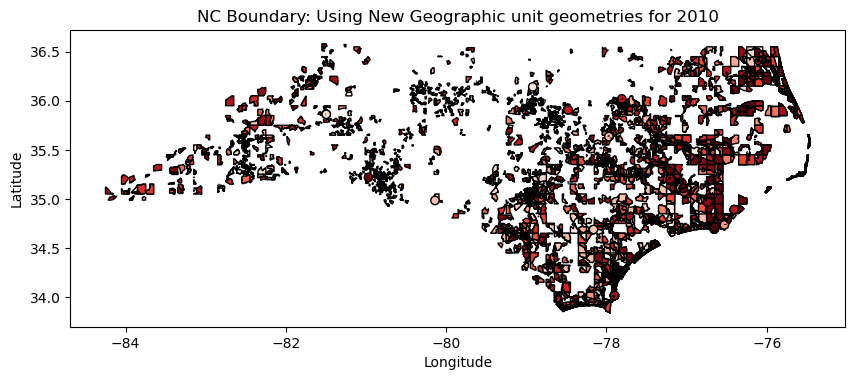

In [203]:
visualize_NC = new_unit_df[(new_unit_df['state'] == 'NC') & (new_unit_df['year'] == 2010)]

# centroids = visualize_NC.geometry.centroid

# # Filter the rows where the y-coordinate (latitude) of the centroid is greater than 42
# visualize_NC = visualize_NC[centroids.y < 37]
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize_NC, geometry='geometry')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.mean()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NC Boundary: Using New Geographic unit geometries for 2010')

plt.show()

In [ ]:
new_unit_df

In [206]:
sum(visualize_NC['geometry'].is_empty)

0

Average Area: 22.199438765735216 square kilometers


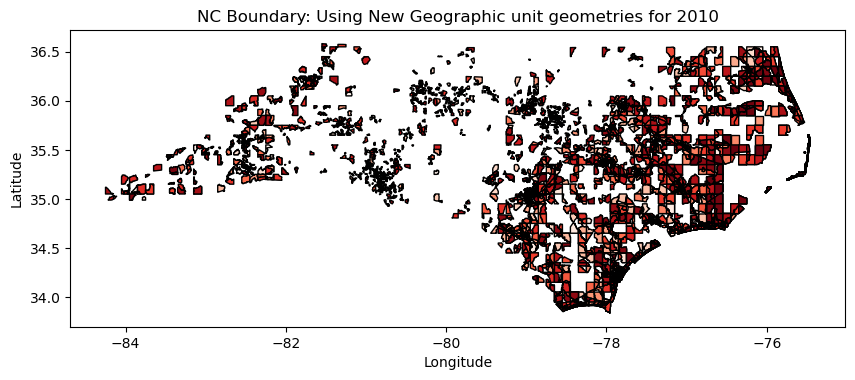

In [217]:
visualize_NC = new_unit_df[(new_unit_df['state'] == 'NC') & (new_unit_df['year'] == 2010)]

# centroids = visualize_NC.geometry.centroid

# # Filter the rows where the y-coordinate (latitude) of the centroid is greater than 42
# visualize_NC = visualize_NC[centroids.y < 37]
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize_NC, geometry='geometry')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.mean()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NC Boundary: Using New Geographic unit geometries for 2010')

plt.show()

In [207]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df = gpd.GeoDataFrame(columns=['geographic_unit_id', 'censusBlockGroupFips', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_1990 and each row in lat_long_df to find intersections
for idx_unit, row_unit in visualize_NC_1.iterrows():
    year = row_unit['yearOfLoss_1990_2021']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    state = row_unit['state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    
    # Compute intersection geometry

    intersection_geometry = bg_geometry.intersection(lat_long_geometry)

    # Check if the intersection result is valid
    # Create a unique ID for the intersection using the year and indices
    geographic_unit_id = f"{year}_{bg_id}_{int(abs(lat) * 10)}_{int(abs(long) * 10)}"

    # Append intersection information to a list
    new_unit_df = pd.concat([new_unit_df, pd.DataFrame({
        'geographic_unit_id': [geographic_unit_id],
        'censusBlockGroupFips': [bg_id],
        'latitude': [lat],
        'longitude': [long],
        'geometry': [intersection_geometry],
        'year': [year],
        'state': [state]
    })], ignore_index=True)

In [208]:
sum(new_unit_df['geometry'].is_empty)

429

In [216]:
new_unit_df[new_unit_df['geometry'].is_empty]

,geographic_unit_id,censusBlockGroupFips,latitude,longitude,geometry,year,state
2,2000_370559705022_353_755,370559705022,35.3,-75.5,POLYGON EMPTY,2000,NC
27,1990_370531104011_364_759,370531104011,36.4,-75.9,POLYGON EMPTY,1990,NC
40,1990_370319701021_350_766,370319701021,35.0,-76.6,POLYGON EMPTY,1990,NC
133,1990_370139306002_355_770,370139306002,35.5,-77.0,POLYGON EMPTY,1990,NC
174,2000_370319701022_348_765,370319701022,34.8,-76.5,POLYGON EMPTY,2000,NC
...,...,...,...,...,...,...,...
15870,2020_371879501006_359_767,371879501006,35.9,-76.7,POLYGON EMPTY,2020,NC
15939,2020_370319701022_348_765,370319701022,34.8,-76.5,POLYGON EMPTY,2020,NC
15945,2020_370139306002_355_770,370139306002,35.5,-77.0,POLYGON EMPTY,2020,NC
15977,2020_370319701022_348_765,370319701022,34.8,-76.5,POLYGON EMPTY,2020,NC


In [213]:
visualize_NC_1.shape[0]

16016

In [214]:
new_unit_df.shape[0]

16016

In [209]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df2 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'ZipCode', 'censusBlockGroupFips', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_1990 and each row in lat_long_df to find intersections
for idx_unit, row_unit in visualize_NC_1.iterrows():
    year = row_unit['yearOfLoss_1990_2021']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    state = row_unit['state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    
    # Compute intersection geometry
    intersection_geometry = bg_geometry.intersection(lat_long_geometry).intersection(zipcode_geometry)

    # Check if intersection_geometry is not None and if the intersection result is valid
    if intersection_geometry is not None:
        # Create a unique ID for the intersection using the year and indices
        geographic_unit_id = f"{year}_{zipcode}_{bg_id}_{int(abs(lat) * 10)}_{int(abs(long) * 10)}"

        # Append intersection information to a list
        new_unit_df2 = pd.concat([new_unit_df2, pd.DataFrame({
            'geographic_unit_id': [geographic_unit_id],
            'ZipCode': [zipcode],
            'censusBlockGroupFips': [bg_id],
            'latitude': [lat],
            'longitude': [long],
            'geometry': [intersection_geometry],
            'year': [year],
            'state': [state]
        })], ignore_index=True)


In [210]:
sum(new_unit_df2['geometry'].is_empty)

1394

In [215]:
 new_unit_df2.shape[0]

15679